In [ ]:
%load_ext autoreload
%autoreload 2
from factor_processing_utils import *

In [62]:
# 研究时间
start_date = "2015-01-01"
end_date = "2025-07-01"

# 基准指数
index_item = "000852.XSHG"
change_days = 20

# 券池
stock_universe = INDEX_FIX(start_date, end_date, index_item)
stock_list = stock_universe.columns.tolist()
date_list = stock_universe.index.tolist()

##### Asness, C. S., Frazzini, A., & Pedersen, L. H. (2019). Quality minus junk. Journal of Finance. 
##### 对 Gordon成长模型的分解定义了质量因子的四个基础组成部分：profitability、growth、payout_ratio, safety
##### 光大证券2018.11.03《以质取胜：EBQC综合质量因子详解》
##### 质量因子：盈利能力、成长能力、营运效率、盈余质量、安全性、公司治理

In [ ]:
## 质量因子
## 全部资产现金回收率 = 经营性现金流/总资产
cfoa_mrq = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
    "total_assets_mrq_0"
)
## 营业利润同比增长率 = （当期营业利润 - 去年同期营业利润）/绝对值（去年同期营业利润）
op_q_yoy_mrq = (
    Factor("profit_from_operation_mrq_0") - Factor("profit_from_operation_mrq_4")
) / ABS(Factor("profit_from_operation_mrq_4"))
## 资产周转率变动 = 当期营业收入/当期总资产 - 去年同期营业收入/去年同期总资产
atdy_mrq = Factor("operating_revenue_mrq_0") / Factor("total_assets_mrq_0") - Factor(
    "operating_revenue_mrq_4"
) / Factor("total_assets_mrq_4")
## 应计利润占比 = 应计利润/营业利润
apr_ttm = (
    Factor("profit_from_operation_ttm_0")
    - Factor("cash_flow_from_operating_activities_ttm_0")
) / Factor("profit_from_operation_ttm_0")
## 现金流动负债率比 = 经营性现金流/流动负债
ccr_mrq = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
    "current_liabilities_mrq_0"
)

# 量价因子


factor_dict = {
    "cfoa_mrq": cfoa_mrq,
    "op_q_yoy_mrq": op_q_yoy_mrq,
    "atdy_mrq": atdy_mrq,
    "apr_ttm": apr_ttm,
    "ccr_mrq": ccr_mrq,
    "liq_zamount": 0,
    "corr_price_turn": 0,
    "vol_high_low_std": 0,
    "mmt_normal_M": 0,
}
factor_names = [
    "cfoa_mrq",
    "op_q_yoy_mrq",
    "atdy_mrq",
    "ccr_mrq",
    "apr_ttm",
    "liq_zamount",
    "corr_price_turn",
    "vol_high_low_std",
    "mmt_normal_M",
]

In [ ]:
import time

for k, v in tqdm(factor_dict.items()):

    # 获取raw因子值
    df = execute_factor(v, stock_list, start_date, end_date)
    raw_path = f"factor_lib/raw/{k}_{index_item}_{start_date}_{end_date}.pkl"
    df.to_pickle(raw_path)
    
    # 清洗之后存入neu文件夹
    neu_path = f"factor_lib/neu/{k}_{index_item}_{start_date}_{end_date}.pkl"
    df = data_clean(df, stock_universe, index_item)
    df.to_pickle(neu_path)

100%|██████████| 4/4 [03:27<00:00, 51.89s/it]


In [74]:
# 从neu文件夹读取因子值，存入value_dict
value_dict = {}
for k, v in tqdm(factor_dict.items()):
    value_dict[k] = pd.read_pickle(
        f"factor_lib/neu/{k}_{index_item}_{start_date}_{end_date}.pkl"
    )

100%|██████████| 9/9 [00:00<00:00, 50.05it/s]


In [75]:
ic_df = pd.DataFrame(index=date_list)
ic_summary = pd.DataFrame()
for k, v in value_dict.items():
    ic, ic_summary_single = calc_ic(v, change_days, index_item, k)
    ic_df = pd.concat([ic_df, ic.to_frame(k)], axis=1)
    ic_summary = pd.concat([ic_summary, ic_summary_single.set_index("name")], axis=0)

{'name': 'cfoa_mrq', 'change_day': 20, 'IC mean': 0.019, 'IC std': 0.052, 'ICIR': 0.3645, 'IC>0': 0.64, 'ABS_IC>2%': 0.7009, 't_stat': 18.3248}
{'name': 'op_q_yoy_mrq', 'change_day': 20, 'IC mean': 0.0326, 'IC std': 0.0702, 'ICIR': 0.4649, 'IC>0': 0.6891, 'ABS_IC>2%': 0.7963, 't_stat': 23.3751}
{'name': 'atdy_mrq', 'change_day': 20, 'IC mean': 0.021, 'IC std': 0.0505, 'ICIR': 0.4167, 'IC>0': 0.6669, 'ABS_IC>2%': 0.7464, 't_stat': 20.9536}
{'name': 'ccr_mrq', 'change_day': 20, 'IC mean': 0.0185, 'IC std': 0.0479, 'ICIR': 0.3862, 'IC>0': 0.6452, 'ABS_IC>2%': 0.6709, 't_stat': 19.4173}
{'name': 'apr_ttm', 'change_day': 20, 'IC mean': 0.0155, 'IC std': 0.0446, 'ICIR': 0.3481, 'IC>0': 0.6479, 'ABS_IC>2%': 0.6748, 't_stat': 17.5018}
{'name': 'liq_zamount', 'change_day': 20, 'IC mean': 0.0521, 'IC std': 0.058, 'ICIR': 0.8975, 'IC>0': 0.8066, 'ABS_IC>2%': 0.7931, 't_stat': 45.125}
{'name': 'corr_price_turn', 'change_day': 20, 'IC mean': 0.0574, 'IC std': 0.0685, 'ICIR': 0.8385, 'IC>0': 0.7931,

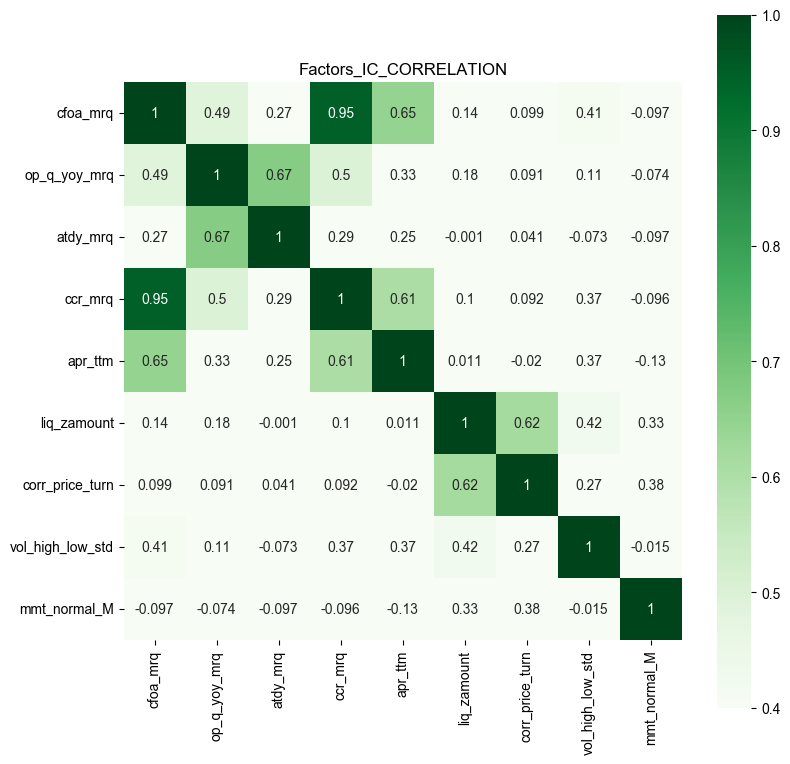

In [76]:
hot_corr(factor_names, ic_df)

{'name': 'ew_combo', 'change_day': 20, 'IC mean': 0.0814, 'IC std': 0.0755, 'ICIR': 1.0786, 'IC>0': 0.8627, 'ABS_IC>2%': 0.8786, 't_stat': 54.2322}


100%|██████████| 128/128 [00:01<00:00, 107.33it/s]


             0
策略累计收益  2.5068
策略年化收益  0.1321
基准累计收益  0.0630
基准年化收益  0.0061
阿尔法     0.1236
贝塔      1.0370
波动率     0.3235
夏普比率    0.3155
下行波动率   0.2786
索提诺比率   0.3664
跟踪误差    0.0608
信息比率    2.0739
最大回撤    0.5660
卡玛比率    0.2333
超额累计收益  2.2989
超额年化收益  0.1252
超额波动率   0.0620
超额夏普    1.5356
超额最大回撤  0.1099
胜率      0.5663
盈亏比     1.1194


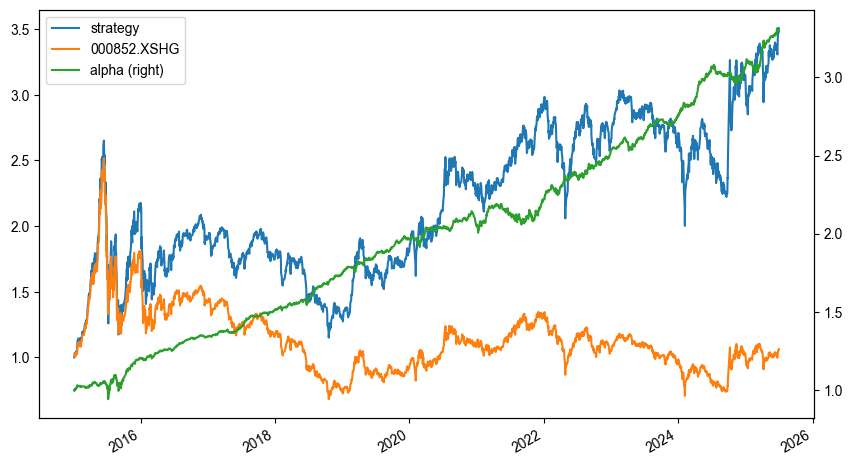

In [78]:
ew_combo = pd.DataFrame()
for factor_name in factor_names:
    ew_combo = ew_combo.add(standardize(value_dict[factor_name]), fill_value=0)
ic, ic_report = calc_ic(ew_combo, 20, index_item, "ew_combo")
buy_list = get_buy_list(ew_combo, rank_n=200)
df_weight = buy_list.div(buy_list.sum(axis=1), axis=0)
df_weight = df_weight.shift(1).dropna(how="all")
account_result = backtest(df_weight)
performance_cumnet, result = get_performance_analysis(
    account_result, benchmark_index=index_item
)

In [67]:
performance_annual_performance = (
    performance_cumnet.pct_change().resample("Y").apply(lambda x: (1 + x).prod() - 1).T
)
display(performance_annual_performance)

,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31,2024-12-31,2025-12-31
strategy,1.153623,-0.178337,-0.123452,-0.294699,0.360809,0.243776,0.308066,-0.101520,0.017950,0.112665,0.094935
000852.XSHG,0.794027,-0.214905,-0.180289,-0.363371,0.247320,0.183264,0.215713,-0.209319,-0.077333,0.060966,0.033657
alpha,0.191551,0.046577,0.069337,0.107868,0.090987,0.051140,0.075966,0.136337,0.103270,0.048727,0.059282
